Recommendation System 1: Recommend by tags

Features: 

    tags

Labels: 

    artist

Label Pipe: 

    show most related art work under the artist

Recommendation System 2: Recommend by images

Features: 

    image

Labels: 

    artist

Label Pipe: 
    
    show most related art work under the artist

Feature Pipeline:

Tags:

    Tags are catagorized by Primary and Secondary. Secondary tags involves 2 tage connected by underscore, similarly Tertiary tags can be generated. 

In [1]:
import csv
from PIL import Image
import requests
import numpy as np
from io import BytesIO
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_size = 1500
creater_sample_threshold = 20
explore_progress = 0

art_tags = defaultdict(set)
art_tags_sec = defaultdict(set)
artsPerCreater = defaultdict(list)
data_x = []
data_y = []

all_arts = []

tag_primary_freq = defaultdict()
tag_relative = defaultdict(set)
tag_secondary_freq = defaultdict()
tag_rel_freq = defaultdict()
with open('safebooru-metadata-2018.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        explore_progress += 1
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            if len(artsPerCreater[row[1]]) >= creater_sample_threshold:
                continue
            art_url = 'http:'+row[-1]
            artsPerCreater[row[1]].append(art_url)
            all_arts.append(art_url)
            #
            tags = np.array(row[5].split())
            art_tags[art_url].add('')
            for i in tags:
                #count primary tag frequency
                if '_' not in i:
                    if i not in tag_primary_freq:
                        tag_primary_freq[i] = 1
                    else:
                        tag_primary_freq[i] = tag_primary_freq[i]+1
                    #add art to tag mapping
                    art_tags[art_url].add(i)
            #
            #data X Y collection
            data_x.append(row)
            data_y.append(str(row[1]))
            line_count += 1
        if line_count == data_size:
            break
    print(f'Processed {line_count} lines.')
    print('file entry explored till line: ',explore_progress)
    
line_count = 1
#secondary tags
for row in data_x:
    tags = np.array(row[5].split())
    #
    for i in tags:
        if '_' in i:
            #record secondary tag parents
            for j in i.split('_'):
                #record prim tag in sec tag
                if j not in tag_rel_freq:
                    tag_rel_freq[j] = 1
                else:
                    tag_rel_freq[j] += 1
                for key in tag_primary_freq:
                    if key in j:
                        tag_relative[key].add(i)
            #record secondary tag frequency
            if i not in tag_secondary_freq:
                tag_secondary_freq[i] = 1
            else:
                tag_secondary_freq[i] += 1
            #add secondary tag dictionary
            art_tags_sec[art_url].add(i)
            #
    line_count += 1
print(f'Processed {line_count} lines.')

Column names are id, creator_id, created_at, width, height, tags, source, file_url
Processed 1500 lines.
file entry explored till line:  1029745
Processed 1500 lines.


Issue:

    Many art tags are only rich in secondary tags, lacking primary tag, which make primary tag based feature vector very deficit. Hence we need to create new primary tag based on the frequeny on componenet in secondary tag. For example, for secondary tag "black_hair", both word "black" and "hair" are high frequency word hence we add primary tag "black" and "hair" for the art.

In [2]:
print(data_y)

#search unqualified sample
unqualify = set()
for creater in artsPerCreater:
    if len(artsPerCreater[creater])<creater_sample_threshold:
        unqualify.add(creater)


['79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '79', '8970', '8970', '8970', '8970', '15218', '17295', '8970', '8970', '8970', '8970', '8970', '8970', '8970', '8970', '8970', '15722', '8970', '8970', '8970', '8970', '8970', '8970', '1510', '8970', '15218', '8724', '8724', '8724', '15218', '24719', '11839', '24697', '8724', '15218', '15218', '15218', '17295', '8724', '15218', '15218', '15218', '17295', '8159', '18099', '642', '15218', '15218', '8724', '15218', '17295', '15722', '8724', '15218', '11191', '18099', '8724', '18484', '18168', '17295', '17295', '17295', '17295', '17295', '17295', '17295', '17295', '17295', '17295', '15218', '18043', '8724', '1477', '18773', '17295', '15218', '15218', '15218', '15218', '15218', '15218', '15911', '15722', '15722', '15722', '8230', '1510', '1510', '18043', '8724', '8724', '8724', '8724', '8724', '8724', '17295', '8724', '18043', '8724', '18099', '18525', '8724', '8724', '15722',

In [3]:
#mark unqualified sample
for i in range(0,len(data_y)):
    for k in unqualify:
         if data_y[i] == k:
            data_y[i] = 'unq'


In [4]:
#create new prim tag based on sec tag frequency with certain threshold
rel_tags = sorted(tag_rel_freq, key=tag_rel_freq.get, reverse=True)[:1000]

for i in art_tags:
    for j in art_tags_sec[i]:
        for k in j.split('_'):
            if k in rel_tags:
                art_tags[i].add(j)

In [5]:
for w in sorted(tag_primary_freq, key=tag_primary_freq.get, reverse=True):
    print(w, tag_primary_freq[w], tag_relative[w])

1girl 648 set()
solo 410 {'solo_focus'}
tagme 326 set()
smile 267 {'smile_precure!', 'nervous_smile', 'light_smile', 'seductive_smile'}
blush 196 {'ear_blush', 'light_blush', 'spoken_blush', 'blush_stickers'}
1boy 151 set()
highres 147 set()
touhou 143 {'sara_(touhou)', 'tokiko_(touhou)', 'yuki_(touhou)', 'junko_(touhou)', 'touhou_(pc-98)', 'seiran_(touhou)'}
breasts 142 {'small_breasts', 'between_breasts', 'largh_breasts', 'bouncing_breasts', 'covering_breasts', 'sagging_breasts', 'huge_breasts', 'medium_breasts', 'hanging_breasts', 'big_breasts', 'large_breasts', 'unaligned_breasts'}
dress 139 {'yellow_dress', 'frilled_dress', 'black_dress', 'vertical-striped_dress', 'purple_dress', 'strapless_dress', 'dress_shirt', 'sailor_dress', 'pink_dress', 'armored_dress', 'striped_dress', 'ruffled_dress', 'green_dress', 'long_dress', 'white_dress', 'short_dress', 'maid_headdress', 'china_dress', 'layered_dress', 'orange_dress', 'multicolored_dress', 'chinese_dress', 'maid_dress', 'wedding_dres

nintendo 18 set()
night 18 {'five_nights_at_freddys', 'florence_nightingale_(fate/grand_order)', 'fate/stay_night', 'wriggle_nightbug', 'night_sky'}
zofis 18 set()
frog 17 {'frog_hair_ornament'}
stewardess 17 set()
yu-gi-oh! 17 {'yu-gi-oh!_the_dark_side_of_dimensions'}
star 17 {'little_twin_stars', 'star_(sky)', 'star_pillow', 'lucky_star', 'sigma_star_saga', 'star_(symbol)', 'idolmaster_cinderella_girls_starlight_stage', 'star_print', 'twinkle_star_(idolmaster)', 'fumutan_of_the_stars', 'star_hair_ornament'}
hairband 17 {'lolita_hairband'}
striped 16 {'striped_gloves', 'striped_dress', 'striped_ribbon', 'striped_bikini', 'vertical-striped_dress', 'striped_thighhighs', 'vertical-striped_shirt', 'diagonal-striped_background', 'striped_background', 'horizontal-striped_legwear', 'striped_stockings', 'striped_bow', 'striped_shirt', 'striped_legwear'}
book 16 {'open_book', 'holding_book', 'book_stack'}
kimono 16 {'white_kimono', 'kimono_skirt'}
stars 16 {'little_twin_stars', 'fumutan_of_the

fish 5 {'fishnet_stockings'}
tareme 5 set()
twins 5 set()
ball 5 {'poke_ball', 'dragon_ball_z', 'cell_(dragon_ball)', 'dragon_ball', 'dragonball_z', 'energy_ball', 'baseball_bat', 'luna_ball', 'snowball_(overwatch)', 'baseball_cap', 'ball_cap', 'crystal_ball', 'north_koreaball', 'soccer_ball', 'endymio_ballad', 'ancient_greeceball', 'luna_ballad'}
stomach 5 {'stomach_top', 'on_stomach'}
gardevoir 5 {'mega_gardevoir'}
embarrassed 5 set()
christmas 5 {'christmas_outfit', 'christmas_tree', 'christmas_hat'}
lingerie 5 {'cat_lingerie'}
sunset 5 set()
dancing 5 {'dancing_pole'}
snekkestsnek 5 set()
cross 5 {'rose_cross', 'cross-laced_footwear', 'crossed_arms', 'scar_across_eye', 'animal_crossing', 'arms_crossed', 'cross_necklace'}
garden 5 {'violet_evergarden'}
headdress 5 {'maid_headdress'}
boy 5 {'multiple_boys', 'young_boys', 'demon_boy', 'young_boy', 'monster_boy', 'cowboy_shot'}
younger 5 set()
bound 5 set()
kirito 5 {'kirito_(sao-ggo)'}
amaterasu 5 set()
okami 5 set()
sash 5 {'musashi_

shadow 2 {'shadow_rise', 'shadow_kanji', 'shadow_yukiko'}
rough 2 {'ears_through_headwear', 'see-through_silhouette', 'see_through', 'ass_visible_through_thighs', 'eyebrows_visible_through_hair'}
2017 2 set()
groin 2 set()
argyle 2 {'argyle_legwear', 'argyle_background'}
pocket 2 {'hand_in_pocket', 'hands_in_pockets'}
kitten 2 set()
spikes 2 set()
nails 2 {'long_fingernails', 'sharp_nails', 'blue_nails', 'purple_nails', 'painted_nails', 'green_nails', 'red_nails', 'black_nails', 'painted_fingernails', 'long_nails'}
excalibur 2 set()
pillar 2 set()
eevee 2 {'eeveeheart151_(character)'}
:q 2 set()
rin-girl 2 set()
cutter 2 set()
bustier 2 set()
coral 2 set()
glowing 2 {'glowing_eyes'}
mantle 2 set()
mermaid 2 set()
silk 2 set()
armlet 2 set()
bandeau 2 set()
circlet 2 set()
curtains 2 set()
objectification 2 set()
kuroyuki 2 set()
drink 2 {'drinking_glass'}
zelda 2 {'the_legend_of_zelda:_skyward_sword', 'the_legend_of_zelda:_breath_of_the_wild', 'the_legend_of_zelda', 'princess_zelda'}
o

noose 1 set()
noose-chan 1 set()
frosting 1 set()
present 1 set()
armpit 1 set()
dogoo 1 set()
open 1 {'open_vest', 'open_mouth', 'open_eyes', 'open_blazer', 'open_clothes', 'center_opening', 'open_skirt', 'open_jacket', 'open_shirt', 'open_arms', 'open_book', 'open_coat', 'open_hoodie', 'open_cuffs', 'open_door', 'mouth_open'}
grey 1 {'grey_skin', 'grey_skirt', 'grey_hoodie', 'grey_hair', 'grey_hairclip', 'grey_eyes', 'grey_background', 'grey_border'}
sadness 1 set()
snowfall 1 set()
sorrow 1 {'king_of_sorrow'}
simple 1 {'simple_background', 'simple_baockground'}
miroku 1 set()
chocolate 1 set()
cooking 1 set()
kitchen 1 set()
jumprope 1 set()
spotlight 1 set()
needle 1 set()
fog 1 set()
snail 1 set()
drums 1 set()
pole 1 {'dancing_pole', 'pole_vault', 'penny_polendina'}
purse 1 set()
radio 1 {'jet_set_radio'}
cell 1 {'cell_(dragon_ball)'}
chicken 1 set()
gears 1 set()
lightbulb 1 set()
airplane 1 {'airplane_interior'}
classroom 1 set()
rice 1 set()
lights 1 {'neon_lights'}
road 1 set

boys 1 {'multiple_boys', 'young_boys'}
mafia 1 set()
man 1 {'rockman_x', 'megane_man', 'iaian_(one_punch_man)', 'mature_woman', 'nanette_manoir', 'mana_(gooney)', 'too_many', 'beatmania_iidx', 'command_spell', 'isshiki_(ffmania7)', 'susan_foreman', 'yamanaka_ino', 'german_flag', 'romana_ii', 'batman_(series)', 'too_many_cats', 'romana_i', 'eromanga_sensei', 'okada_manabi', 'x_(rockman)', 'amano_madoka', 'mint_blancmanche', 'fat_man', 'amane_suzuha', 'too_many_frills', 'onepunch_man', 'no_humans', 'gates_oltsman', 'ubermangaka_(character)', 'ugly_man'}
hammer 1 {'hammer_and_sickle'}
kimmy77 1 set()
yuusa 1 set()
tokisakijp 1 set()
cutoffs 1 set()
kukkumann 1 set()
3: 1 set()
sunsun69 1 set()
flowers 1 {'flowers_in_hair', 'red_flowers'}
gao 1 set()
rainbow 1 {'rainbow_dash'}
dreamsaddiction 1 set()
toned 1 set()
exercise 1 set()
salute 1 set()
snk 1 set()
shochuumimai 1 set()
tomizofu 1 set()
confetti 1 set()
glint 1 set()
plectrum 1 set()
parka 1 set()
sidecut 1 set()
tecmo 1 set()
peng

pipe 1 set()
ella 1 {'isabella_(dobutsu_no_mori)', 'holding_umbrella', 'arrabella_rose', 'arcueid_brunestudarrabella_aurora', 'idolmaster_cinderella_girls_starlight_stage', 'transparent_umbrella', 'idolmaster_cinderella_girls', 'isabella_valentine', 'blake_belladonna', 'alisa_ilinichina_amiella'}
horror 1 set()
m.u.g.e.n. 1 set()
mugen 1 set()
pedobear 1 set()
ambition 1 set()
devichonee 1 set()
redraw 1 set()
lovely 1 set()
zangoose 1 set()
2012 1 set()
ionixis 1 set()
skitty 1 set()
dexter 1 {"dexter's_laboratory", 'rude_dexter'}
halo 1 {'mechanical_halo'}
laboratory 1 {"dexter's_laboratory"}
rocket 1 set()
sakikomana 1 set()
tutu 1 set()
tram 1 set()
tyranitar 1 set()
ho-oh 1 set()
girafarig 1 set()
gyarados 1 set()
beedrill 1 set()
drawinggen1 1 set()
vulpix 1 set()
candle 1 set()
graveyard 1 set()
rosenkreuz 1 set()
jackdaw 1 set()
hatsune 1 {'hatsune_miku'}
miku 1 {'sakura_miku', 'sakura_miku_dayo', 'hatsune_miku', 'zatsune_miku'}
artist 1 {'naoko_(artist)', 'miko_(artist)', 'art

submersible 1 set()
wetsuit 1 set()
apc-300 1 set()
hk69a1 1 set()
swat 1 set()
animalization 1 set()
fedora 1 set()
mikkii 1 set()
lamia 1 set()
hamster 1 set()
hamtaro 1 {'hamtaro_(hamtaro)'}
fate/zero 1 set()
oekaki 1 set()
pan!ies 1 set()
seeu 1 set()
touching 1 set()
beautiful 1 set()
chipmunk 1 set()
mobian 1 set()
wjstpwls4 1 set()
dc 1 {'cardcaptor_sakura', 'dc_comics'}
logo 1 set()
shocked 1 set()
arrancar 1 set()
espada 1 set()
hole 1 {'whole_body', 'cat_keyhole_bra', 'smelling_butthole'}
justice 1 set()
superhero 1 set()
comics 1 {'dc_comics'}
marvel 1 set()
morrigan 1 set()
spider 1 {'spider_lily', 'spider_web'}
leafa 1 set()
lisbeth 1 {'lisbeth_(sao-alo)'}
silica 1 {'silica_(sao-alo)'}
3four 1 set()
garid 1 set()
hetero 1 set()
chkuyomi 1 set()
ghoul:re 1 set()
tokyo 1 {'tokyo_mew_mew'}
cry 1 {'sieg_(fate/apocrypha)', 'crystal_ball', 'jack_the_ripper_(fate/apocrypha)', 'battle_cry', 'crystal_(pokemon)'}
roses 1 set()
gelgoog 1 {'gelgoog_jager'}
rifle 1 {'beam_rifle', 'assa

Ctagorical feature encoding:

One hot encoding primary features
Oridinal variable endoing to secondary features based on one hot encoding  
secondary encoding can result in multiple change in one-hot schema point

In [6]:
#ONE-HOT-ENCODING
from sklearn.preprocessing import MultiLabelBinarizer
import copy
indexToArt= {}
artToIndex = {}
encodedTPA = []
encodedTagList = []
index = 0
for i in art_tags:
    indexToArt[index] = i
    artToIndex[i] = index
    index = index + 1
    encodedTPA.append(list(art_tags[i]))

one_hot = MultiLabelBinarizer()
encodedTPA = one_hot.fit_transform(encodedTPA)
encodedTPA  = encodedTPA * 10
print(one_hot.classes_)
encodedTagList = copy.deepcopy(one_hot.classes_)
print(len(encodedTPA))
print("encoded dimension is: ",len(encodedTPA[0]))
print(np.where(encodedTPA[0]==1))

['' '!' '+00s' ..., 'zofis' 'zuikaku_(kantai_collection)' '子野日']
1499
encoded dimension is:  4274
(array([], dtype=int64),)


Training set feature extraction:

baseline:

    now we have primary tag feature as one-hot-encoded
    increment on primary tag code if associated secondary tag is found

In [7]:
train_x = []
train_y = data_y
for i in range(0,data_size-1):
    art_id = indexToArt[i]
    cur_x = encodedTPA[i]
    for sec_tag in art_tags_sec[art_id]:
        for prim_tag in art_tags[art_id]:
            if prim_tag in sec_tag:
                #primary tag position
                prim_tag_index = np.where(encodedTagList==prim_tag)
                #increment code
                cur_x[prim_tag_index] += 1
    train_x.append(cur_x)
            

In [8]:
#unqualify filter
for i in np.where(np.array(train_y)=='unq')[0][::-1]:
    train_y.pop(i)
    train_x.pop(i)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y) 
pred_y = neigh.predict(train_x)
print('train accuracy: ',accuracy_score(train_y,pred_y))

train accuracy:  0.689285714286


In [10]:
from sklearn import linear_model
    
mod = linear_model.LogisticRegression(penalty='l2',C=1,random_state=423)
mod.fit(train_x, train_y) 
pred_y = mod.predict(train_x)
print("logistic regression: ")
print("valid accuracy: ",accuracy_score(train_y,pred_y))

logistic regression: 
valid accuracy:  0.959523809524


In [11]:
'''
def tagToFeature(tagList):
    featureList = [0]*len(encodedTagList)
    for i in tagList:
        if '_' not in i:
            if i in encodedTagList:
                tag_index = np.where(encodedTagList==i)
                featureList[tag_index]=1
        else:
            featureList = secTagEncode(featureList,i)
    return featureList

def secTagEncode(f_list,secTag):
    res = copy.deepcopy(f_list)
    for i in encodedTagList:
        if i in secTag:
            tag_index = np.where(encodedTagList==i)
            for k in tag_index[0]:
                res[k]+=1
    return res

def recommendations(tagList):
    rec_creater = neigh.predict([tagToFeature(tagList)])
    art_url = artsPerCreater[(rec_creater[0])][0]
    print(art_url)
    response = requests.get(art_url)
    img = Image.open(BytesIO(response.content))
    imgplot = plt.imshow(img)
    plt.show()
    return rec_creater
'''
def tagToFeature(tagList):
    featureList = [0]*len(encodedTagList)
    for i in tagList:
        if '_' not in i:
            if i in encodedTagList:
                tag_index = np.where(encodedTagList==i)
                print(tag_index)
                for k in tag_index[0]:
                    #featureList[k]=1
                    featureList[k]=5
        else:
            featureList = secTagEncode(featureList,i)
    print('encoded index: ')
    return featureList

def secTagEncode(f_list,secTag):
    res = copy.deepcopy(f_list)
    for i in encodedTagList:
        if i in secTag:
            tag_index = np.where(encodedTagList==i)
            for k in tag_index[0]:
                res[k]+=1
    return res
#recommendation on one artist
def recommendations(tagList,predict_func):
    rec_creater = predict_func([tagToFeature(tagList)])
    print('recommended artist ID: ',rec_creater)
    print('related art to the tag')
    for art_url in artsPerCreater[(rec_creater[0])]:
        if searchTag(art_url,tagList):
            response = requests.get(art_url)
            img = Image.open(BytesIO(response.content))
            imgplot = plt.imshow(img)
            plt.show()
    return rec_creater


#top n artists recommendation
def recommendations_top_n(tagList,predictor,n):
    probs = predictor.predict_proba([tagToFeature(tagList)])
    best_n = np.argsort(probs, axis=1)[:,-n:]
    best_n_classes = []
    for i in best_n[0]:
        best_n_classes.append(predictor.classes_[i])
    print(best_n)
    print('recommended top ',n,'artists ID: ',best_n_classes)
    print('related art to the tag')
    for rec_creater in best_n_classes:
        for art_url in artsPerCreater[rec_creater]:
            if searchTag(art_url,tagList):
                response = requests.get(art_url)
                img = Image.open(BytesIO(response.content))
                imgplot = plt.imshow(img)
                plt.show()
    return rec_creater

#local search on predicted artist
def searchTag(art_url,tagList):
    for tags in art_tags[art_url]:
        for tag in tagList:
            if tag in tags:
                return True
    for tags in art_tags_sec[art_url]:
        for tag in tagList:
            if tag in tags:
                return True
    return False

(array([1433]),)
encoded index: 
recommended artist ID:  ['13041']
related art to the tag


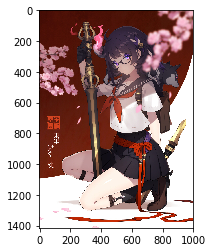

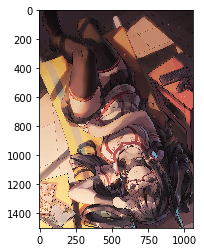

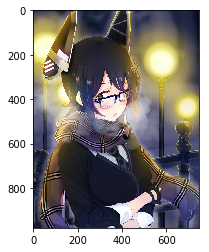

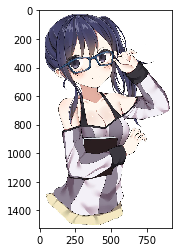

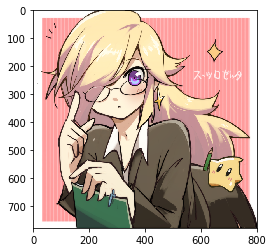

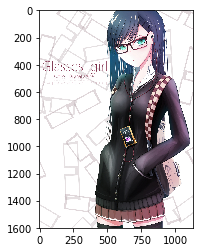

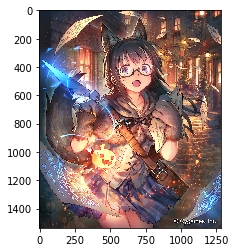

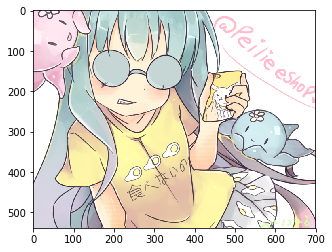

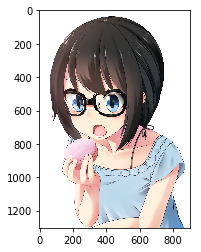

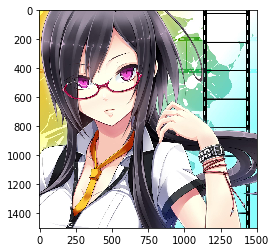

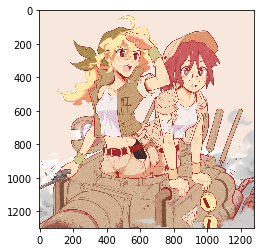

array(['13041'],
      dtype='<U5')

In [12]:
#define your search tag here
search_tag = ['glasses']

#recommend one artist
recommendations(search_tag,mod.predict)

In [13]:
#recommend top 3 similar artists
#recommendations_top_n(search_tag,mod,3)